In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import torch

In [2]:
class CustomOptimizer(torch.optim.Optimizer):
    def __init__(self, params, lr=0.1, WD=0.003):
        if lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if WD < 0.0:
            raise ValueError("Invalid weight_decay value: {}".format(WD))

        defaults = dict(lr=lr, WD=WD)
        super(CustomOptimizer, self).__init__(params, defaults)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                lr = group['lr']
                WD = group['WD']

                p.data = (p.data - lr * grad) /(1 + lr * WD / torch.abs(p.data))
    

        return loss
    

class CustomAdamW(torch.optim.AdamW):
    def __init__(self, params, lr=1e-3, WD_0=0.01, *args, **kwargs):
        # Transform params into separate groups for each parameter
        individual_params = [{'params': [p]} for p in params]
        
        super(CustomAdamW, self).__init__(individual_params, lr=lr, weight_decay=WD_0, *args, **kwargs)
        self.WD_0 = WD_0
        self.lr = lr

    def step(self, closure=None):
        # Before the optimizer step, update the weight decay for each parameter
        for param_group in self.param_groups:
            for param in param_group['params']:
                if param.grad is None:
                    continue
                param_group['weight_decay'] = self.WD_0 / (torch.abs(param).mean().item() + self.WD_0) * self.lr

        # Call the parent class step function
        return super(CustomAdamW, self).step(closure)
    



import copy


class CustomSGD(torch.optim.SGD):
    def __init__(self, params, lr, momentum=0, dampening=0,
                 weight_decay=0, nesterov=False, WD=0.01):
        super(CustomSGD, self).__init__(params, lr=lr, momentum=momentum, 
                                        dampening=dampening, weight_decay=weight_decay, 
                                        nesterov=nesterov)
        self.WD = WD

    def step(self, closure=None):
        # Store the original parameters
        original_params = copy.deepcopy(self.param_groups)

        # Call the base SGD step first
        loss = super(CustomSGD, self).step(closure)

        # Apply custom weight decay using the original parameters
        for group, original_group in zip(self.param_groups, original_params):
            lr = group['lr']
            for p, orig_p in zip(group['params'], original_group['params']):
                if p.grad is None:
                    continue
                # Apply custom weight decay using original parameters
                p.data /= (1 + lr * self.WD / torch.abs(orig_p.data))

        return loss

In [18]:
# inits

n = 1000
q = 7/10
q_zeros=7/10
steps = 400
lmbda = 0.1
thresh=0.005
lr = 0.1
N_iters = 30


# Setting up random seeds for reproducibility
torch.manual_seed(98736)


# Initialize teacher vector

T = torch.randn(n)
T = T/torch.norm(T)
# n_normal = int(n * (1 - q_zeros))
# T = np.concatenate([np.zeros(n - n_normal), np.random.normal(0, 1, n_normal)])
# T=torch.Tensor(T/np.sqrt(np.dot(T,T)))


# Initialize student vector
Si = torch.nn.Parameter(torch.randn(n)/np.sqrt(q*n))

D=Si-T

# Generate data
X = torch.randn(int(q*n), n)
Sigma = X.T @ X / (q*n)

# Define the training loss function (as defined earlier)
def training_loss_fn(S, T, Sigma):
    difference = S - T
    loss = difference.T @ Sigma @ difference
    return loss

# Define the validation loss function
def validation_loss_fn(S, T):
    difference = S - T
    return torch.dot(difference, difference)


def grad_train(S, T, Sigma):
    difference = S - T
    grad = 2* Sigma @ difference
    return grad


# Compute SVD of Sigma
U, S, V = torch.svd(Sigma)

# Find the columns of V that correspond to near-zero singular values (i.e., the null space)
threshold = 1e-5  # A threshold to identify nearly zero singular values
null_space_basis = V[:, S < threshold]

# Project D onto the null space of Sigma to get D_null
D_null = null_space_basis @ (null_space_basis.T @ D)


# Compute ||D_null||_2^2
norm_D_null_squared = torch.norm(D_null)**2

100%|██████████| 100/100 [00:36<00:00,  2.75it/s]


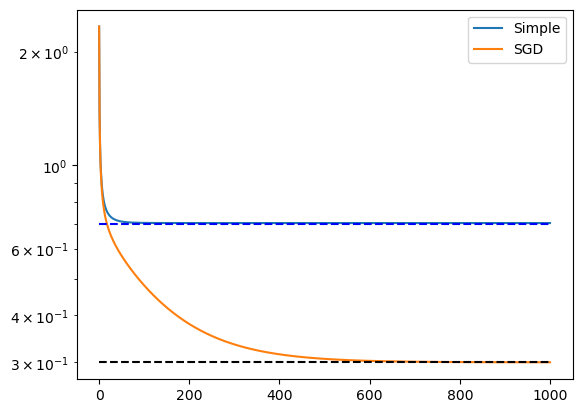

In [22]:
# Define number of runs
num_runs = 100

# Define lists to store all loss histories and weight histograms for each run
all_loss_history_simple = []
all_loss_history_SGD = []
all_weight_hist_S_SGD = []
all_weight_hist_S_simple = []

# Setting up random seeds for reproducibility
torch.manual_seed(98736)


for run in tqdm.trange(num_runs):
    
    # Generate new data
    X = torch.randn(int(q*n), n)
    Sigma = X.T @ X / (q*n)
    
    # Reset initial student vectors
    S_simple = Si.clone().detach().requires_grad_(True)
    S_SGD = Si.clone().detach().requires_grad_(True)
    
    # Initialize optimizers
    optimizer_simple = torch.optim.SGD([S_simple], lr=lr, weight_decay=0, momentum=0.0)
    optimizer_SGD = torch.optim.SGD([S_SGD], lr=lr, weight_decay=WD, momentum=0.0)
    
    # Initialize loss histories for this run
    loss_history_simple = [validation_loss_fn(S_simple, T).item()]
    loss_history_SGD = [validation_loss_fn(S_SGD, T).item()]
    
    for epoch in range(epochs):
        
        optimizer_simple.zero_grad()
        optimizer_SGD.zero_grad()

        # Forward pass
        loss_simple = training_loss_fn(S_simple, T, Sigma)
        loss_SGD = training_loss_fn(S_SGD, T, Sigma)

        # Backward pass
        loss_simple.backward()
        loss_SGD.backward()

        # Optimizer step
        optimizer_simple.step()
        optimizer_SGD.step()

        # Append history
        loss_history_simple.append(validation_loss_fn(S_simple, T).item())
        loss_history_SGD.append(validation_loss_fn(S_SGD, T).item())
        
    # Append loss histories for this run
    all_loss_history_simple.append(loss_history_simple)
    all_loss_history_SGD.append(loss_history_SGD)
    
    # Collect weight data for histograms
    all_weight_hist_S_SGD.append(np.log10(np.abs(S_SGD.detach().numpy()) + 1e-13))
    all_weight_hist_S_simple.append(np.log10(np.abs(S_simple.detach().numpy()) + 1e-13))




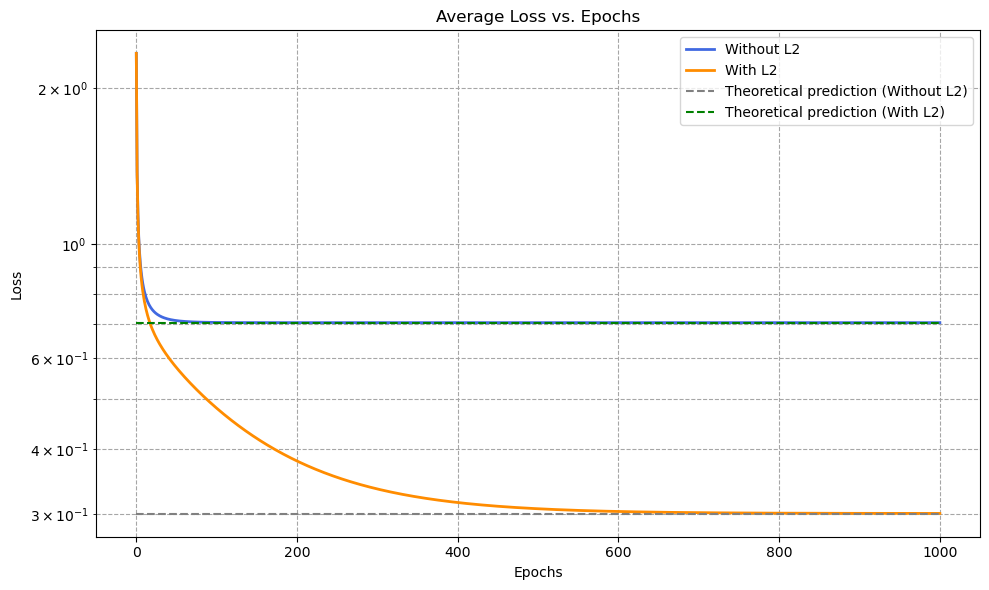

In [23]:
# Compute average loss histories over all runs
avg_loss_history_without_L2 = np.mean(all_loss_history_simple, axis=0)
avg_loss_history_with_L2 = np.mean(all_loss_history_SGD, axis=0)

# Plot average loss histories
plt.figure(figsize=(10, 6))
plt.semilogy(avg_loss_history_without_L2, label='Without L2', color='royalblue', linewidth=2)
plt.semilogy(avg_loss_history_with_L2, label='With L2', color='darkorange', linewidth=2)
plt.hlines(1-q, 0, epochs, color='gray', ls='--', label='Theoretical prediction (Without L2)')
plt.hlines((1-q) * ((Si - T) @ (Si - T)).item(), 0, epochs, color='green', ls='--', label='Theoretical prediction (With L2)')
plt.title('Average Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, which="both", ls="--", c='0.65')
plt.tight_layout()
plt.show()


In [26]:
lam_max=(1+q**0.5)**2
lam_min=(1-q**0.5)**2

kappa=lam_max/lam_min


lam_max*lam_min/(lam_max-lam_min), -1/np.log((kappa-1)/(kappa+1))

(0.026892643710023856, 63.21694946269016)

100%|██████████| 1000/1000 [00:00<00:00, 2518.22it/s]


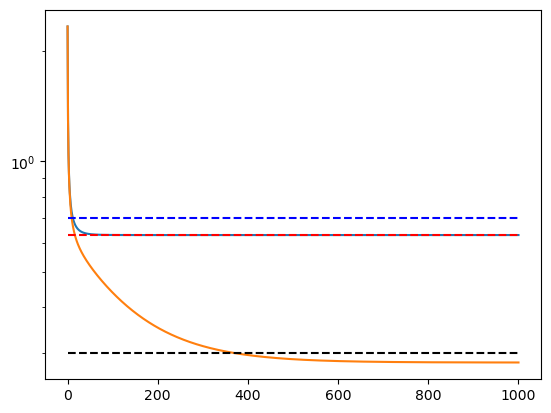

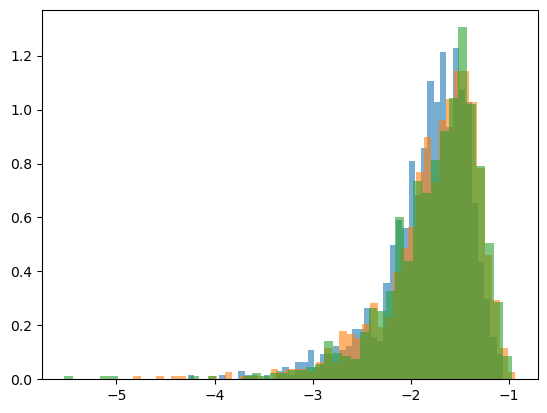

In [19]:
# Training loop
epochs = 1000  # Adjust as needed
lr=0.2
WD=0.02

S_simple=Si.clone().detach().requires_grad_(True)
S_SGD=Si.clone().detach().requires_grad_(True)
loss_history_simple=[validation_loss_fn(S_simple,T).item()]
loss_history_SGD=[validation_loss_fn(S_SGD,T).item()]


# optimizer_simple = CustomOptimizer([S_simple], lr=1.1*lr, WD=WD/35)
optimizer_simple=torch.optim.SGD([S_simple], lr=lr, weight_decay=0, momentum=0.0)
# optimizer_SGD = CustomSGD([S_SGD], lr=lr, WD=WD, momentum=0.2)
optimizer_SGD = torch.optim.SGD([S_SGD], lr=lr, weight_decay=WD, momentum=0.0)

for epoch in tqdm.trange(epochs):

    optimizer_simple.zero_grad()
    optimizer_SGD.zero_grad()
    
    # Forward pass
    loss_simple = training_loss_fn(S_simple, T, Sigma)
    loss_SGD = training_loss_fn(S_SGD, T, Sigma)
    
    # Backward pass
    loss_simple.backward()
    loss_SGD.backward()
    
    # Optimizer step
    optimizer_simple.step()
    optimizer_SGD.step()
    
    # append history
    loss_history_simple.append(validation_loss_fn(S_simple, T).item())
    loss_history_SGD.append(validation_loss_fn(S_SGD, T).item())

plt.semilogy(loss_history_simple)
plt.plot(loss_history_SGD)
plt.hlines(1-q,0,epochs, color='k', ls='--')
plt.hlines((1-q)*((Si-T)@(Si-T)).item(),0,epochs, color='b', ls='--')
plt.hlines(norm_D_null_squared.item(),0,epochs, color='r', ls='--')

plt.show()

plt.hist(np.log10(np.abs(S_SGD.detach().numpy())+1e-13),bins=50,alpha=0.6,density=True)
plt.hist(np.log10(np.abs(T)+1e-13),bins=50,alpha=0.6,density=True)

plt.hist(np.log10(np.abs(S_simple.detach().numpy())+1e-13),bins=50,alpha=0.6, density=True)
plt.show()

In [6]:
(4*(1-q)**4/q)**0.5

0.21514114968019094

In [29]:
def train_and_compute_loss(lr, WD):
    """
    Train the model with the provided learning rate and weight decay.
    
    Args:
    - lr (float): learning rate
    - WD (float): weight decay
    
    Returns:
    - float: validation loss after training
    """
    
    # Initialize the model (student vector in your case)
    S = Si.clone().detach().requires_grad_(True)
    
    # Initialize optimizer with given lr and WD
    optimizer = CustomOptimizer([S], lr=lr, WD=WD)
    
    # Training loop
    epochs = 10000  # Adjust as needed
    loss_history = []

    for epoch in range(epochs):
        optimizer.zero_grad()
        
        # Forward pass
        loss = training_loss_fn(S, T, Sigma)
        
        # Backward pass
        loss.backward()
        
        # Optimizer step
        optimizer.step()
        
        # Append to history (you can use this for plotting or early stopping if desired)
        loss_history.append(validation_loss_fn(S, T).item())
    
    # Return the final validation loss
    return loss_history[-1]


lr=0.13;
WD=0.0014/q**3;
q=0.95;

lr_cur=lr
WD_cur=WD

optimal=[lr_cur,WD_cur,1]
IJ=[1,1]
for i in range(20):
    WD_cur=1.2*optimal[1]
    optimal_temp=[lr_cur,WD_cur,train_and_compute_loss(lr_cur,WD_cur)]
    for j in range(20):
        

        if optimal_temp[2]<optimal[2]:
            optimal=optimal_temp;
            IJ=[i+1,j+1]
        WD_cur=q*WD_cur
        optimal_temp=[lr_cur,WD_cur,train_and_compute_loss(lr_cur,WD_cur)]
        print(f"Iteration {i+1,j+1}: lr={optimal[0]:.4f}, WD={optimal[1]:.4f}, Loss={optimal[2]:.4f}, best inds={IJ}", end='\r')


    lr_cur=q*lr_cur




In [149]:
def optimize_hyperparameters(initial_WD, lr_range, f, n_scan_points=100, tol=1e-4, max_iters=100):
    best_WD = initial_WD
    prev_loss = float('inf')
    best_loss = prev_loss
    iters = 0
    no_improvement_iters = 0

    # Step 1: Initial scan over lr_range
    lrs = np.linspace(lr_range[0], lr_range[1], n_scan_points)
    losses = [train_and_compute_loss(WD=best_WD, lr=lr) for lr in lrs]

    best_lr = lrs[np.argmin(losses)]
    best_loss = min(losses)
    prev_loss = best_loss

    print(f"Initial best values: lr={best_lr:.4f}, WD={best_WD:.4f}, Loss={best_loss:.4f}")

    while iters < max_iters:
        # Search around best_lr for possible better values
        lrs = np.linspace(0.9*best_lr, 1.1*best_lr, 10)  # refining search around best_lr
        losses = [train_and_compute_loss(WD=best_WD, lr=lr) for lr in lrs]
        
        current_best_lr = lrs[np.argmin(losses)]
        current_best_loss = min(losses)
        
        # Also evaluate loss for decayed WD
        decayed_WD_loss = train_and_compute_loss(WD=best_WD*f, lr=current_best_lr)

        if current_best_loss < best_loss - tol:  # Check if there's an improvement
            best_lr = current_best_lr
            best_loss = current_best_loss
            no_improvement_iters = 0  # Reset the no improvement counter
        elif decayed_WD_loss < best_loss - tol:  # Check if decaying WD leads to improvement
            best_WD *= f
            best_loss = decayed_WD_loss
            no_improvement_iters = 0
        else:
            no_improvement_iters += 1

        # Break if no significant improvement for several iterations
        if no_improvement_iters >= 20:
            print("No significant improvement for several iterations. Stopping search.")
            break
        
        print(f"Iteration {iters}: lr={best_lr:.4f}, WD={best_WD:.4f}, Loss={best_loss:.4f}", end='\r')
        iters += 1
        
    print(f"\nFinal best values: lr={best_lr:.4f}, WD={best_WD:.4f}, Loss={best_loss:.4f}")
    return best_lr, best_WD, best_loss


optimize_hyperparameters(2e-2, [0.2,0.05], 0.9, n_scan_points=20, tol=1e-7, max_iters=100)


Initial best values: lr=0.0579, WD=0.0200, Loss=0.1059
No significant improvement for several iterations. Stopping search.

Final best values: lr=0.0779, WD=0.0063, Loss=0.0364


(0.07793450289590004, 0.006276211921800004, 0.03642240911722183)

100%|██████████| 3/3 [00:17<00:00,  5.94s/it]


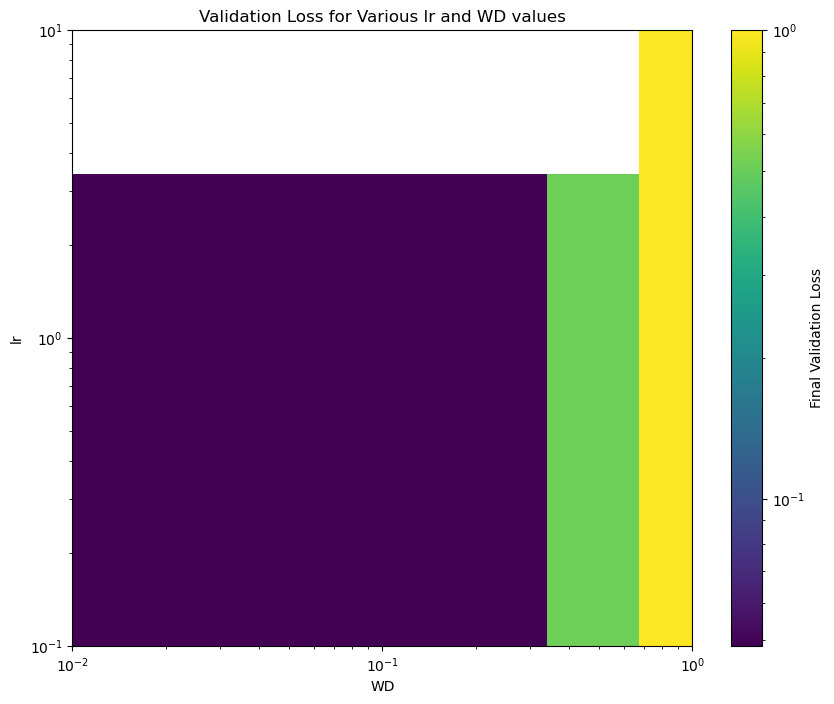

In [84]:
# Define the ranges for lr and WD
lr_values = np.logspace(-1, 1, 3)  # for example, from 0.001 to 1
WD_values = np.logspace(-2, -0, 3)  # for example, from 0.0001 to 0.1

# Placeholder for the final validation losses
final_losses = np.zeros((len(lr_values), len(WD_values)))

# Loop over lr and WD values
for j, WD in enumerate(tqdm.tqdm(WD_values)):
    for i, lr in enumerate(lr_values):    
        S_temp = Si.clone().detach().requires_grad_(True)
        optimizer = CustomOptimizer([S_temp], lr=lr, WD=WD)
        
        for epoch in range(epochs):
            optimizer.zero_grad()
            loss = training_loss_fn(S_temp, T, Sigma)
            loss.backward()
            optimizer.step()
            
        final_losses[i, j] = validation_loss_fn(S_temp, T).item()

from matplotlib.colors import LogNorm

plt.figure(figsize=(10, 8))
plt.imshow(final_losses, origin='lower', aspect='auto', extent=[np.min(WD_values), np.max(WD_values), np.min(lr_values), np.max(lr_values)], norm=LogNorm())
plt.colorbar(label='Final Validation Loss')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('WD')
plt.ylabel('lr')
plt.title('Validation Loss for Various lr and WD values')
plt.show()


100%|██████████| 20/20 [01:55<00:00,  5.78s/it]


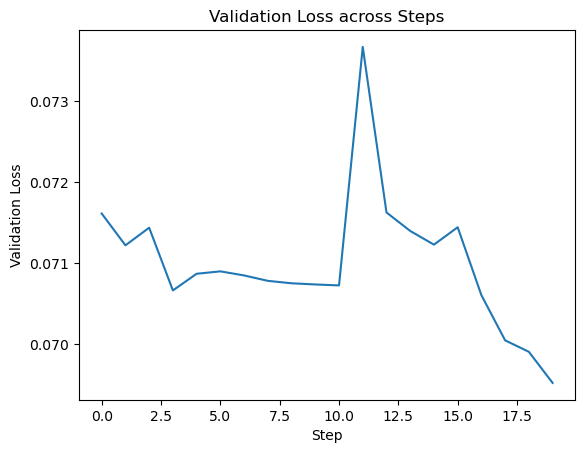

In [94]:


# Initial values
lr, WD = 0.01, 0.003
R = 1.01
N_iter = 20

# Store the losses
loss_history = []

# Gradient-based hyperparameter optimization loop
for _ in tqdm.trange(N_iter):
    # Compute loss at (lr, WD)
    base_loss = train_and_compute_loss(lr, WD)
    
    # Compute loss with scaled lr
    lr_scaled_loss = train_and_compute_loss(R * lr, WD)
    
    # Compute loss with scaled WD
    wd_scaled_loss = train_and_compute_loss(lr, R * WD)
    
    # Estimate gradients
    lr_gradient = (lr_scaled_loss - base_loss) / (R - 1.0)
    wd_gradient = (wd_scaled_loss - base_loss) / (R - 1.0)
    
    # Update lr and WD - here you can use a small step size for the updates
    lr -= (R - 1.0) * lr_gradient
    WD -= (R - 1.0) * wd_gradient
    
    loss_history.append(base_loss)

# Plotting the loss
plt.plot(loss_history)
plt.xlabel('Step')
plt.ylabel('Validation Loss')
plt.title('Validation Loss across Steps')
plt.show()


100%|██████████| 100/100 [00:21<00:00,  4.70it/s]


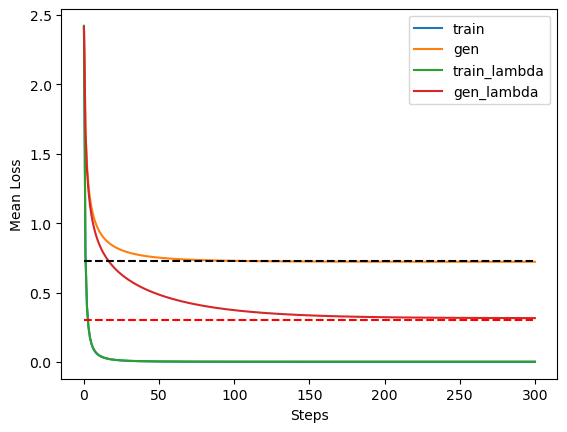

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import tqdm

n = 1000
q = 7/10
steps = 300
lmbda = 0.1
lr = 0.1
N_iters = 100

T = np.random.normal(0, 1/np.sqrt(q * n), n)
T=T/np.sqrt(np.dot(T,T))

def ltr(S, Sigma):
    return np.dot(S - T, Sigma @ (S - T))

def lgen(S):
    return np.dot(S - T, S - T)

def g(S, Sigma):
    return 2 * Sigma @ (S - T)

def computeLosses(iter):
    X = np.random.normal(0, 1, (int(q * n), n))
    Sigma = X.T @ X / (q * n)
    S0 = np.random.normal(0, 1/np.sqrt(q * n), n)
    S = S0
    S2 = S0
    LS_tr = [ltr(S0, Sigma)]
    LS_gen = [lgen(S0)]
    LS_tr_lambda = [ltr(S2, Sigma)]
    LS_gen_lambda = [lgen(S2)]
    for i in range(steps):
        S = S - lr * g(S, Sigma)
        S2 = (S2 - lr * g(S2, Sigma)) / (1 + lr * lmbda)
        LS_tr.append(ltr(S, Sigma))
        LS_gen.append(lgen(S))
        LS_tr_lambda.append(ltr(S2, Sigma))
        LS_gen_lambda.append(lgen(S2))
    return LS_tr, LS_gen, LS_tr_lambda, LS_gen_lambda, np.dot(S0, S0)

allResults = Parallel(n_jobs=-1)(delayed(computeLosses)(i) for i in tqdm.trange(N_iters))

# Initialize accumulators
CumLS_tr = np.zeros(steps + 1)
CumLS_gen = np.zeros(steps + 1)
CumLS_tr_lambda = np.zeros(steps + 1)
CumLS_gen_lambda = np.zeros(steps + 1)
mean_S0_dot = 0.0

# Accumulate results
for res in allResults:
    CumLS_tr += res[0]
    CumLS_gen += res[1]
    CumLS_tr_lambda += res[2]
    CumLS_gen_lambda += res[3]
    mean_S0_dot += res[4]

# Calculate means
MeanLS_tr = CumLS_tr / N_iters
MeanLS_gen = CumLS_gen / N_iters
MeanLS_tr_lambda = CumLS_tr_lambda / N_iters
MeanLS_gen_lambda = CumLS_gen_lambda / N_iters
mean_S0_dot /= N_iters

# Plotting
plt.figure()
plt.plot(MeanLS_tr, label="train")
plt.plot(MeanLS_gen, label="gen")
plt.plot(MeanLS_tr_lambda, label="train_lambda")
plt.plot(MeanLS_gen_lambda, label="gen_lambda")
plt.plot([(1 - q)*(1+mean_S0_dot)] * steps, 'k--')
plt.plot([(1 - q)] * steps, 'r--')
plt.legend()
plt.xlabel("Steps")
plt.ylabel("Mean Loss")
plt.show()


100%|██████████| 30/30 [00:06<00:00,  4.93it/s]


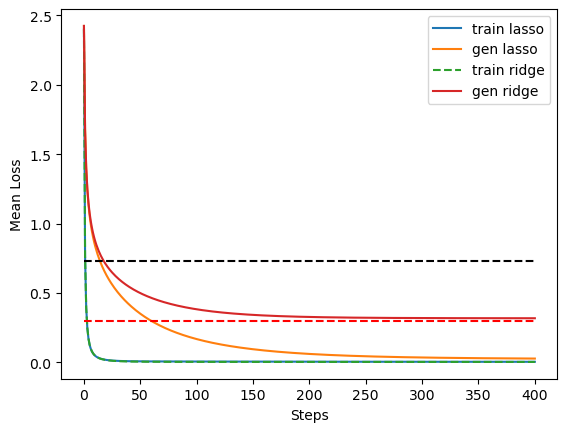

In [52]:
n = 1000
q = 7/10
q_zeros=7/10
steps = 400
lmbda = 0.1
thresh=0.005
lr = 0.1
N_iters = 30

# T = np.random.normal(0, 1, n)
n_normal = int(n * (1 - q_zeros))
T = np.concatenate([np.zeros(n - n_normal), np.random.normal(0, 1, n_normal)])
T=T/np.sqrt(np.dot(T,T))



def soft_threshold(x, lam):
    return np.sign(x) * np.maximum(0, np.abs(x) - lam)


def computeLosses(iter):
    X = np.random.normal(0, 1, (int(q * n), n))
    Sigma = X.T @ X / (q * n)
    S0 = np.random.normal(0, 1/np.sqrt(q * n), n)
    S = S0
    S2 = S0
    LS_tr_lasso = [ltr(S, Sigma)]
    LS_gen_lasso = [lgen(S)]
    LS_tr_lambda = [ltr(S2, Sigma)]
    LS_gen_lambda = [lgen(S2)]
    for i in range(steps):
        S = soft_threshold(S - lr * g(S, Sigma),lr * thresh)
        S2 = (S2 - lr * g(S2, Sigma)) / (1 + lr * lmbda)
        LS_tr_lasso.append(ltr(S, Sigma))
        LS_gen_lasso.append(lgen(S))
        LS_tr_lambda.append(ltr(S2, Sigma))
        LS_gen_lambda.append(lgen(S2))
    return LS_tr_lasso, LS_gen_lasso, LS_tr_lambda, LS_gen_lambda, np.dot(S0, S0)

allResults = Parallel(n_jobs=-1)(delayed(computeLosses)(i) for i in tqdm.trange(N_iters))

# Initialize accumulators
CumLS_tr_lasso = np.zeros(steps + 1)
CumLS_gen_lasso = np.zeros(steps + 1)
CumLS_tr_lambda = np.zeros(steps + 1)
CumLS_gen_lambda = np.zeros(steps + 1)
mean_S0_dot = 0.0

# Accumulate results
for res in allResults:
    CumLS_tr_lasso += res[0]
    CumLS_gen_lasso += res[1]
    CumLS_tr_lambda += res[2]
    CumLS_gen_lambda += res[3]
    mean_S0_dot += res[4]

# Calculate means
MeanLS_tr_lasso = CumLS_tr_lasso / N_iters
MeanLS_gen_lasso = CumLS_gen_lasso / N_iters
MeanLS_tr_lambda = CumLS_tr_lambda / N_iters
MeanLS_gen_lambda = CumLS_gen_lambda / N_iters
mean_S0_dot /= N_iters

# Plotting
plt.figure()
plt.plot(MeanLS_tr_lasso, label="train lasso")
plt.plot(MeanLS_gen_lasso, label="gen lasso")
plt.plot(MeanLS_tr_lambda, label="train ridge",ls='--')
plt.plot(MeanLS_gen_lambda, label="gen ridge")
plt.plot([(1 - q)*(1+mean_S0_dot)] * steps, 'k--')
plt.plot([(1 - q)] * steps, 'r--')
plt.legend()
plt.xlabel("Steps")
plt.ylabel("Mean Loss")
plt.show()


In [49]:
np.sum(T==0)

801

In [169]:
import torch


# Setting up random seeds for reproducibility
torch.manual_seed(0)

N = 1000      # For example, adjust as needed
q = 0.7      # Given q<1

# Initialize teacher vector
# T = torch.randn(N)
# T = T/torch.norm(T)

n_normal = int(n * (1 - q_zeros))
T = np.concatenate([np.zeros(n - n_normal), np.random.normal(0, 1, n_normal)])
T=torch.Tensor(T/np.sqrt(np.dot(T,T)))


# Initialize student vector
Si = torch.nn.Parameter(torch.randn(N)/np.sqrt(q*N))

# Generate data
X = torch.randn(int(q*N), N)
Sigma = X.T @ X / (q*N)

# Define the training loss function (as defined earlier)
def training_loss_fn(S, T, Sigma):
    difference = S - T
    loss = difference.T @ Sigma @ difference
    return loss

# Define the validation loss function
def validation_loss_fn(S, T):
    difference = S - T
    return torch.dot(difference, difference)


def grad_train(S, T, Sigma):
    difference = S - T
    grad = 2* Sigma @ difference
    return grad
    


In [170]:
(Si-T)@(Si-T)

tensor(2.5432, grad_fn=<DotBackward0>)

In [333]:
Si

Parameter containing:
tensor([-4.2553e-02, -4.3555e-02, -9.4710e-03, -1.6399e-02,  3.2078e-02,
         2.6155e-02, -1.1944e-02, -7.9948e-02,  1.2181e-02, -4.7750e-02,
         1.3228e-02,  1.1646e-02,  4.5296e-03,  4.6779e-02,  4.2210e-02,
        -9.3462e-03, -5.1126e-02, -6.4100e-02,  2.1417e-02,  2.9992e-02,
         2.2634e-02, -5.8777e-02, -1.2902e-02,  7.0037e-02,  2.8354e-02,
        -2.2130e-02, -6.5538e-03,  6.9348e-03,  5.2513e-02,  5.9958e-02,
         3.5767e-02, -3.1888e-02, -2.3191e-02,  1.1941e-03, -1.8621e-02,
         9.3892e-03,  1.6619e-02,  4.2487e-03,  2.4220e-02,  1.6674e-02,
        -3.8669e-03,  2.9952e-02, -1.0948e-02,  1.9846e-03,  1.9762e-02,
         8.7015e-02, -5.5519e-02, -5.9971e-02, -2.5440e-02,  3.2990e-02,
         3.9889e-02,  6.7219e-03, -8.7059e-03, -1.4807e-02,  2.0535e-02,
        -1.4936e-02, -1.6865e-02,  2.8121e-02,  5.7488e-02,  1.2890e-01,
        -5.7873e-02, -4.6646e-02,  6.8779e-02, -2.0846e-02, -2.1516e-02,
         3.4772e-02,  4.1985e

In [352]:
# Training loop
epochs = 10000  # Adjust as needed
lr=0.1
WD=0.003
S=Si.clone().detach().requires_grad_(True)#Si.data.clone()
S2=Si.data.clone()
loss_history=[validation_loss_fn(S,T).detach().numpy()]
loss_history2=[validation_loss_fn(S2,T)]
for epoch in tqdm.trange(epochs):
    S=(S-lr*grad_train(S,T,Sigma))/(1+lr*WD/torch.abs(S))
    S2=(S2-lr*grad_train(S2,T,Sigma))/(1+lr*WD)
    loss_history.append(validation_loss_fn(S,T).detach().numpy())
    loss_history2.append(validation_loss_fn(S2,T))


100%|██████████| 10000/10000 [00:17<00:00, 569.69it/s]


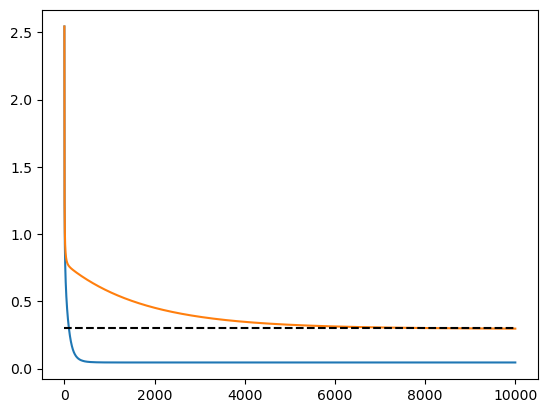

In [353]:
plt.plot(loss_history)
plt.plot(loss_history2)
plt.hlines(1-q,0,epochs, color='k', ls='--')
plt.show()

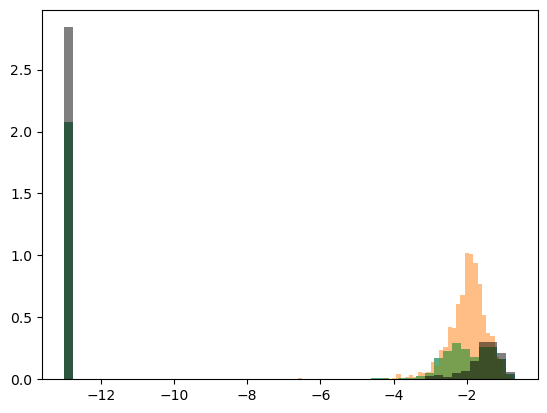

In [357]:
plt.hist(np.log10(np.abs(S.detach().numpy())+1e-13),bins=50, alpha=0.5,density=True)
plt.hist(np.log10(np.abs(S2)+1e-13),bins=50, alpha=0.5,density=True)
plt.hist(np.log10(np.abs(S3.detach().numpy())+1e-13),bins=50, alpha=0.5,density=True)
plt.hist(np.log10(np.abs(T)+1e-13),bins=50, alpha=0.5,color='k',density=True)

# plt.hist(S3.detach().numpy(),bins=50, alpha=0.5)
# plt.hist(S2,bins=50, alpha=0.5)
# plt.hist(T,bins=50, alpha=0.5,color='k')
# plt.hist(Si.detach().numpy(),bins=50, alpha=0.5)
plt.show()

In [338]:
torch.Tensor(S3)

tensor([-1.0470e-04,  4.0300e-06, -2.2403e-03, -2.3410e-07,  6.6698e-05,
        -1.0065e-05, -1.8769e-05, -1.1061e-04, -6.0361e-05, -4.7083e-06,
         2.1688e-03,  1.7838e-04,  1.9996e-04,  2.0924e-03, -9.4612e-05,
        -2.3764e-04, -7.5279e-03, -2.2099e-03,  3.2022e-04,  3.1527e-03,
         6.3974e-05, -1.9615e-04, -1.3444e-03, -2.9058e-05,  1.1230e-03,
         3.9855e-04,  6.8002e-05, -1.9138e-05, -3.7196e-05,  2.6901e-04,
        -2.2743e-04,  2.9285e-04, -6.7042e-03,  1.2411e-03, -1.1114e-03,
        -1.9488e-04,  6.2393e-06,  8.2378e-05, -1.1947e-03,  3.0208e-04,
         3.0575e-04,  3.5514e-04, -2.4926e-03,  8.8568e-05, -6.0469e-03,
        -2.3918e-04,  9.8721e-08, -6.1492e-03, -1.7572e-04,  1.4317e-03,
         3.0825e-03,  4.3011e-04, -4.6385e-04,  1.4925e-04, -1.5801e-03,
        -5.7560e-03,  9.9618e-04,  3.2540e-03,  6.7540e-03, -3.3144e-03,
         1.0779e-05, -7.0497e-06,  4.2458e-03,  1.7028e-06,  1.8123e-05,
        -1.5008e-04, -2.5548e-05,  7.2383e-05,  1.9

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:02<00:00, 4727.70it/s]


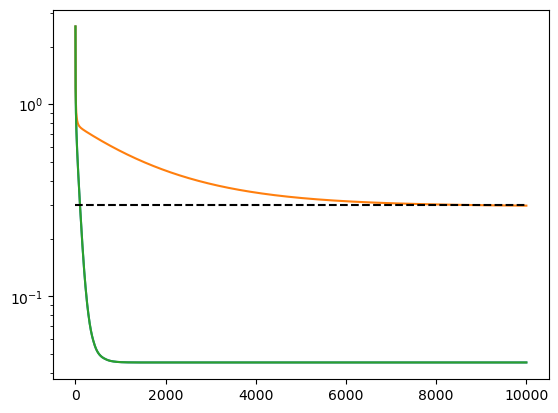

In [356]:
S3 = Si.clone().detach().requires_grad_(True)
# Instantiate the custom optimizer
# optimizer = torch.optim.SGD([S3], lr=0.1, weight_decay=0.003,momentum=0.9,nesterov=True)
# optimizer = torch.optim.AdamW([S3], lr=0.1, weight_decay=0.03,betas=(0.99,0.99))
optimizer = CustomOptimizer([S3], lr=0.1, WD=0.003)#,momentum=0.9, nesterov=True)

loss_function = training_loss_fn

loss_history3 = [validation_loss_fn(S3, T).item()]
for epoch in tqdm.trange(epochs):
    optimizer.zero_grad()
    
    # Forward pass
    loss = loss_function(S3, T, Sigma)
    
    # Backward pass
    loss.backward()
    
    # Optimizer step
    optimizer.step()
    
    loss_history3.append(validation_loss_fn(S3, T).item())

plt.semilogy(loss_history)
plt.plot(loss_history2)
plt.plot(loss_history3)
plt.hlines(1-q,0,epochs, color='k', ls='--')
plt.show()

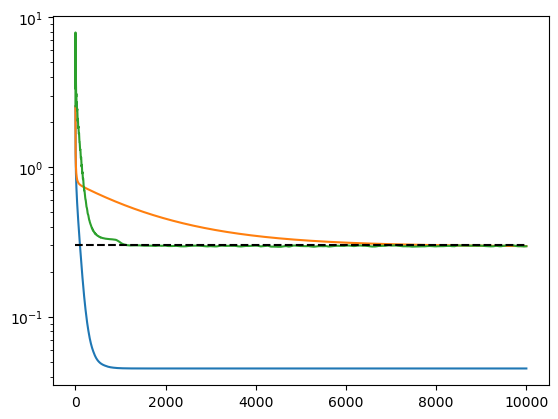

In [268]:
plt.semilogy(loss_history)
plt.plot(loss_history2)
plt.plot(loss_history3)
plt.hlines(1-q,0,epochs, color='k', ls='--')
plt.show()

In [263]:



# Custom AdamW optimizer (as previously defined)
class CustomAdamW(torch.optim.AdamW):
    def __init__(self, params, lr=1e-3, WD_0=0.01, *args, **kwargs):
        super(CustomAdamW, self).__init__(params, lr=lr, weight_decay=WD_0, *args, **kwargs)
        self.WD_0 = WD_0
        self.lr = lr

    def step(self, closure=None):
        # Before the optimizer step, update the weight decay for each parameter
        for param_group in self.param_groups:
            for param in param_group['params']:
                if param.grad is None:
                    continue
                param_group['weight_decay'] = self.WD_0 / (torch.abs(param).mean().item() + self.WD_0) * self.lr

        # Call the parent class step function
        return super(CustomAdamW, self).step(closure)

# optimizer = CustomAdamW([S], lr=0.1, WD_0=0.1)

# # Lists to store losses for plotting
# train_losses = []
# validation_losses = []

# # Training loop
# epochs = 100000  # Adjust as needed

# for epoch in range(epochs):
#     optimizer.zero_grad()
#     train_loss = training_loss_fn(S, T, X)
#     train_loss.backward()
#     optimizer.step()
    
#     # Compute validation loss
#     val_loss = validation_loss_fn(S, T)
    
#     # Append losses for plotting
#     train_losses.append(train_loss.item())
#     validation_losses.append(val_loss.item())
    
#     # Print loss (for example, every 100 epochs)
#     if epoch % 10000 == 0:
#         print(f"Epoch {epoch}, Training Loss: {train_loss.item()}, Validation Loss: {val_loss.item()}")

# # Plotting the losses
# plt.figure(figsize=(10, 5))
# plt.plot(train_losses, label='Training Loss')
# plt.plot(validation_losses, label='Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.title('Training vs. Validation Loss')
# plt.grid(True)
# plt.show()

In [89]:
# Setting up random seeds for reproducibility
torch.manual_seed(1)

N = 1000      # For example, adjust as needed
q = 0.8      # Given q<1

# Initialize teacher vector
T = torch.randn(N)
T=T/torch.norm(T)

n_normal = int(n * (1 - q_zeros))
T = np.concatenate([np.zeros(n - n_normal), np.random.normal(0, 1, n_normal)])
T=torch.Tensor(T/np.sqrt(np.dot(T,T)))

# Initialize two student vectors: one for Custom AdamW and one for Regular AdamW
S_custom = torch.nn.Parameter(torch.randn(N)/np.sqrt(q*N))
S_reg = torch.nn.Parameter(S_custom.data.clone())  # Ensure they start from the same values

S_custom.mean()

tensor(-0.0022, grad_fn=<MeanBackward0>)

# wait

Epoch 0, Validation Loss (Custom AdamW): 1.8478022813796997, Validation Loss (Regular AdamW): 1.8476495742797852
Epoch 10000, Validation Loss (Custom AdamW): 0.8629486560821533, Validation Loss (Regular AdamW): 0.5325987339019775
Epoch 20000, Validation Loss (Custom AdamW): 0.6583091020584106, Validation Loss (Regular AdamW): 0.3876499533653259
Epoch 30000, Validation Loss (Custom AdamW): 0.5312478542327881, Validation Loss (Regular AdamW): 0.35411959886550903
Epoch 40000, Validation Loss (Custom AdamW): 0.4552241563796997, Validation Loss (Regular AdamW): 0.3445196747779846
Epoch 50000, Validation Loss (Custom AdamW): 0.4103243947029114, Validation Loss (Regular AdamW): 0.3414536714553833
Epoch 60000, Validation Loss (Custom AdamW): 0.3835534453392029, Validation Loss (Regular AdamW): 0.34022679924964905
Epoch 70000, Validation Loss (Custom AdamW): 0.3676156997680664, Validation Loss (Regular AdamW): 0.339680552482605
Epoch 80000, Validation Loss (Custom AdamW): 0.3577720522880554, Va

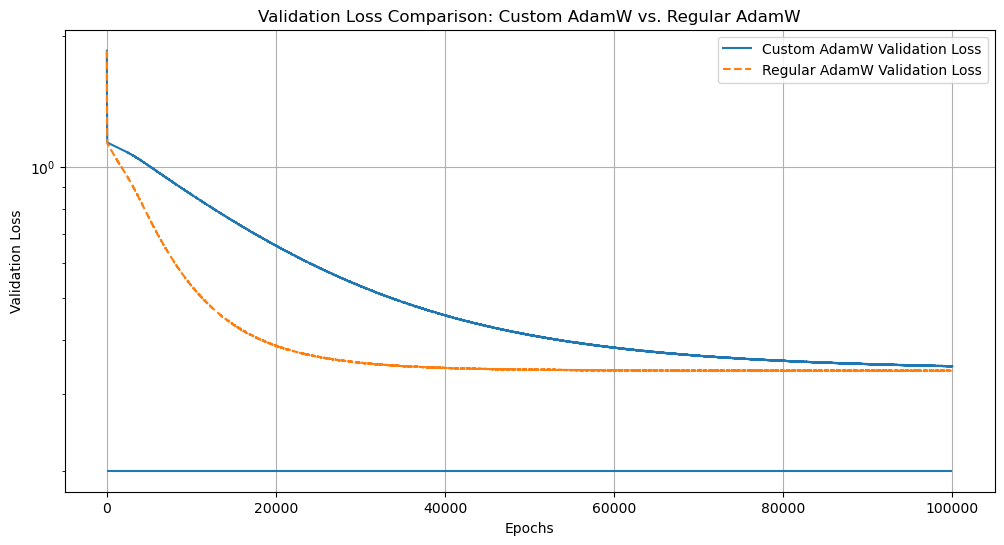

In [67]:


# Set up two optimizers
optimizer_custom = CustomAdamW([S_custom], lr=0.01, WD_0=0.01)
optimizer_reg = torch.optim.AdamW([S_reg], lr=0.01, weight_decay=0.01)

# Lists to store validation losses for plotting
validation_losses_custom = []
validation_losses_reg = []

epochs = 100000  # Adjust as needed
# Training loop
for epoch in range(epochs):
    # Training and updating with Custom AdamW
    optimizer_custom.zero_grad()
    train_loss_custom = training_loss_fn(S_custom, T, X)
    train_loss_custom.backward()
    optimizer_custom.step()
    
    # Training and updating with Regular AdamW
    optimizer_reg.zero_grad()
    train_loss_reg = training_loss_fn(S_reg, T, X)
    train_loss_reg.backward()
    optimizer_reg.step()
    
    # Compute validation losses
    val_loss_custom = validation_loss_fn(S_custom, T)
    val_loss_reg = validation_loss_fn(S_reg, T)
    
    # Append validation losses for plotting
    validation_losses_custom.append(val_loss_custom.item())
    validation_losses_reg.append(val_loss_reg.item())
    
    # Print validation losses (for example, every 1000 epochs)
    if epoch % 10000 == 0:
        print(f"Epoch {epoch}, Validation Loss (Custom AdamW): {val_loss_custom.item()}, Validation Loss (Regular AdamW): {val_loss_reg.item()}")

# Plotting the validation losses for both optimizers
plt.figure(figsize=(12, 6))
plt.semilogy(validation_losses_custom, label='Custom AdamW Validation Loss')
plt.plot(validation_losses_reg, label='Regular AdamW Validation Loss', linestyle='--')
plt.hlines((1-q),0,epochs)
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.legend()
plt.title('Validation Loss Comparison: Custom AdamW vs. Regular AdamW')
plt.grid(True)
plt.show()


In [55]:
import matplotlib.pyplot as plt

# Convert tensors to numpy for plotting
S_custom_np = S.detach().cpu().numpy()
S_reg_np = S2.detach().cpu().numpy()

# Plotting histograms
plt.figure(figsize=(12, 6))

plt.hist(S, bins=50, alpha=0.5, label='S_custom', color='blue')
plt.hist(S2, bins=50, alpha=0.5, label='S_reg', color='red')
plt.hist(T, bins=50, alpha=0.5, label='T', color='green')

plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histograms of S_custom and S_reg')
plt.legend(loc='upper right')

plt.grid(True)
plt.show()


NameError: name 'S2' is not defined

In [39]:
(1-q)+0.01**2*q/(1-q)**3/4

0.20249999999999996